In [1]:
import os
import gc
import sys
import pdb
import copy
import glob
import psutil
import imageio
import calendar
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from memory_profiler import memory_usage
from matplotlib.patches import Rectangle
from cftime import DatetimeNoLeap as date
from matplotlib.colors import TwoSlopeNorm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 14,   # Axis labels
    'xtick.labelsize' : 12,   # X-axis tick labels
    'ytick.labelsize' : 12,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()
#mpl.use('Agg')
#%matplotlib agg

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)
fix_dtint   = putil.adjust_10daily_integrated_tendency
shift_dtint = putil.shift_integrated_tendency
sig         = putil.filter_significance
cmn         = putil.get_cmap_norm

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/wavePaperFigs/util')
import nclcmaps as ncm

In [4]:
importlib.reload(putil)
importlib.reload(ces)
from IPython.display import clear_output

# ----- get data
kwargs = {'freq':'monthly', 'return_intersection':False, 'return_members':True, 'skip_nosrctag':False}
T_           = putil.get_variable('T', **kwargs)
u_           = putil.get_variable('U', **kwargs)
utendepfd_   = putil.get_variable('utendepfd', **kwargs)
utendresvel_ = putil.get_variable('utendresvel', **kwargs)
utendgw_     = putil.get_variable('utendgw', **kwargs)
utenddiff_   = putil.get_variable('utenddiff', **kwargs)
epfy_        = putil.get_variable('epfy', **kwargs)
epfz_        = putil.get_variable('epfz', **kwargs)
psitem_      = putil.get_variable('psitem', **kwargs)
psitem_gp_   = putil.get_variable('psitem_gradlat', **kwargs)
psitem_glat_ = putil.get_variable('psitem_gradp', **kwargs)
trop_        = putil.get_variable('TROP_P', **kwargs)
clear_output()

In [5]:
importlib.reload(putil)
importlib.reload(ces)

# ----- extract counterfactual ensemble mean and members
T, T_mem                     = T_['cfmean'], T_['cf_members']
u, u_mem                     = u_['cfmean'], u_['cf_members']
utendepfd, utendepfd_mem     = utendepfd_['cfmean'], utendepfd_['cf_members']
utendresvel, utendresvel_mem = utendresvel_['cfmean'], utendresvel_['cf_members']
utendgw, utendgw_mem         = utendgw_['cfmean'], utendgw_['cf_members']
utenddiff, utenddiff_mem     = -utenddiff_['cfmean'], -utenddiff_['cf_members']
epfy, epfy_mem               = epfy_['cfmean'], epfy_['cf_members']
epfz, epfz_mem               = epfz_['cfmean'], epfz_['cf_members']
psitem, psitem_mem           = psitem_['cfmean'], psitem_['cf_members']
psitem_gp, psitem_gp_mem     = psitem_gp_['cfmean'], psitem_gp_['cf_members']
psitem_glat, psitem_glat_mem = psitem_glat_['cfmean'], psitem_glat_['cf_members']
trop, trop_mem               = trop_['cfmean'], trop_['cf_members']

# ----- combine data, make month coordinate
allvars = [T, u, utendepfd, utendresvel, utendgw, utenddiff, epfy, epfz, psitem, psitem_gp, psitem_glat, trop]
cf = xr.merge(allvars)

# ----- combine member-level data, make month coordinate
allvars = [T_mem, u_mem, utendepfd_mem, utendresvel_mem, utendgw_mem, utenddiff_mem, 
           epfy_mem, epfz_mem, psitem_mem, psitem_gp_mem, psitem_glat_mem, trop_mem]
cf_mem = xr.merge(allvars)
N = len(cf_mem.ens)

# ----- get climatology
climo = putil.climatology(cf)

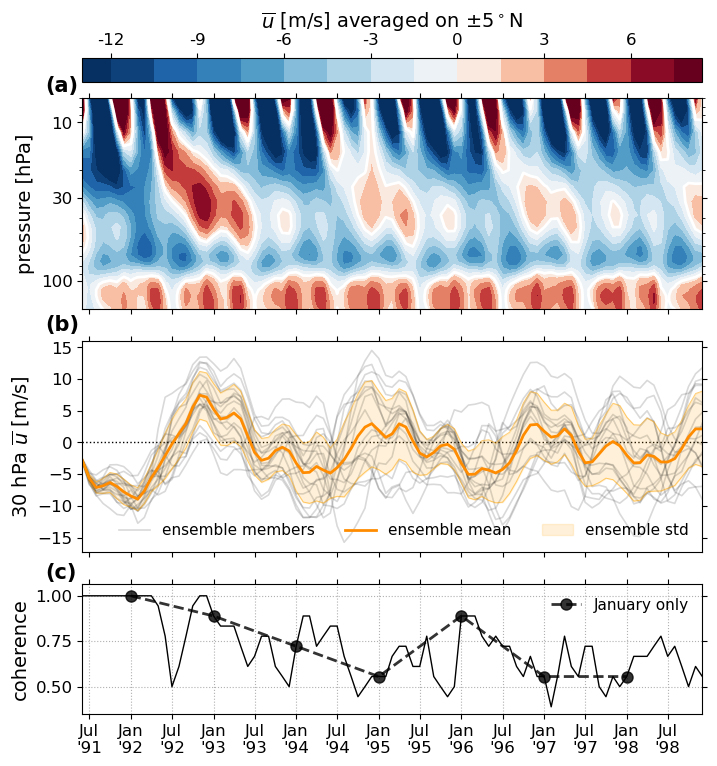

In [19]:
importlib.reload(putil)
importlib.reload(ces)

# --- make figure
gs = GridSpec(8, 1, hspace=0.65)
fig = plt.figure(figsize=(8,8))
ax1  = fig.add_subplot(gs[:3,:])
ax2  = fig.add_subplot(gs[3:6,:])
ax3  = fig.add_subplot(gs[6:,:])

# ---- get dims and data
latb = 5
plev = cf.plev
time = putil.to_datetime(cf.time)
cf_trop           = cf.sel(lat=slice(-latb,latb)).mean('lat')
cf_members_trop   = cf_mem.sel(lat=slice(-latb,latb)).mean('lat')
climo_trop        = climo.sel(lat=slice(-latb,latb)).mean('lat')

# ----- plotting settings
topt = {'option':'solstice', 'include_year':True, 'year_delimiter':'\n'}
ulev = np.arange(-12, 7.6, 1.5)
#ulev = np.hstack([np.arange(-12, 1, 2), np.arange(1, 8, 1)])
ucmap = 'RdBu_r'
ylim = [7, 150]
tlim = [datetime(1991,6,1),datetime(1998,12,1)]

# ------- plot tropical U contours in time-lev
uc = ax1.contourf(time, plev, cf_trop['U'], ulev, cmap=ucmap, extend='both', 
                  norm=putil.get_cmap_norm(ulev, 'twoslope'))
ax1.contour(time, plev, cf_trop['U'], [0], colors='w', linewidths=2)
ax1.set_ylim(ylim)
putil.format_paxis(ax1)
putil.season_timeticks(ax1, time, **topt)
putil.format_ticks(ax1, x=None)
ax1.set_ylabel('pressure [hPa]')
# --- colorbar
cbpos = [0.125, 0.9, 0.775, 0.03] # colorbar position
cb = fig.colorbar(uc, cax=fig.add_axes(cbpos), orientation='horizontal', location='top', 
                  format=FuncFormatter(putil.cbarfmt), extendrect=True)
cb.set_label('$\\overline{{u}}$ [m/s] averaged on $\\pm5^\\circ$N'.format(-latb, latb))
cb.set_ticks(ulev)
cb.ax.xaxis.set_label_position('top')
cb.ax.xaxis.set_ticks(ulev[ulev%1 == 0])
    
# ----- plot winds at 30 hPa
mems30 = cf_members_trop['U'].sel(plev=30, method='nearest')
mems_mean =  mems30.mean('ens')
mems_std  =  mems30.std('ens')
for i in range(N):
    mem = mems30.isel(ens=i)
    label = [None, 'ensemble members'][i==0]
    ax2.plot(time, mem, '-', color='k', lw=1.2, alpha=0.15, label=label)
ax2.plot(time, mems_mean, '-', color='darkorange', lw=2, label='ensemble mean')
ax2.fill_between(time, y1=mems_mean-mems_std, y2=mems_mean+mems_std, color='orange', alpha=0.15, label='ensemble std')
ax2.plot(time, mems_mean-mems_std, '-', color='orange', alpha=0.5, lw=0.7)
ax2.plot(time, mems_mean+mems_std, '-', color='orange', alpha=0.5, lw=0.7)
ax2.axhline(y=0, ls=':', color='k', lw=1, zorder=0)
ax2.yaxis.set_ticks([-15, -10, -5, 0, 5, 10, 15])
ax2.set_xlim(tlim)
#ax2.set_ylim([-16, 19])
putil.season_timeticks(ax2, time, **topt)
putil.format_ticks(ax2, x=None)
ax2.set_ylabel('30 hPa $\\overline{{u}}$ [m/s]')
legend = ax2.legend(loc='lower right', fancybox=False, edgecolor='k', framealpha=1, ncol=3, frameon=False, fontsize=11)
legend.get_frame().set_linewidth(0.66)
#for y in range(1992,1999):
#    ax2.axvline(x=datetime(y,1,1), ls=':', lw=0.88, color='k', alpha=0.33)

# ----- plot coherence at 30 hPa
cf30 = cf_trop['U'].sel(plev=30, method='nearest')
coherence = np.sign(mems30) == np.sign(cf30)
coherence = coherence.sum(dim='ens') / N
cc = coherence
jan_coherence = cc.sel(time=cc.time.where((cc.time.dt.year>1991)&(cc.time.dt.month==1), drop=True))
ax3.plot(putil.to_datetime(jan_coherence.time.values), jan_coherence, '--o', color='k', lw=2, ms=8, alpha=0.8, label='January only', zorder=10)
ax3.plot(putil.to_datetime(cc.time.values), cc, '-k', lw=1)
ax3.grid(ls=':')
ax3.set_xlim(tlim)
putil.season_timeticks(ax3, time, **topt)
putil.format_ticks(ax3)
ax3.set_ylabel('coherence')
ax3.set_ylim([0.35, 1.066])
legend = ax3.legend(loc='upper right', fancybox=False, edgecolor='k', framealpha=1, frameon=False, fontsize=11)
legend.get_frame().set_linewidth(0.66)

# ----- label subplotsx
ax1.annotate('(a)', xy=(-0.06, 1.03), xycoords="axes fraction", fontsize=15, weight='bold')
ax2.annotate('(b)', xy=(-0.06, 1.05), xycoords="axes fraction", fontsize=15, weight='bold')
ax3.annotate('(c)', xy=(-0.06, 1.04), xycoords="axes fraction", fontsize=15, weight='bold')

plt.savefig('figs/qbo_spread.pdf', dpi=200)
plt.show()